# RSS18 Scenario 1

This is "Scenario 1" of the Mars exploration-inspired example that appeared in the following paper:

Petter Nilsson, Sofie Haesaert, Rohan Thakker, Kyohei Otsu, Cristian-Ioan Vasile, Ali-akbar Agha-Mohammadi, Aaron D. Ames and Richard M. Murray, **Toward Specification-Guided Active Mars Exploration for Cooperative Robot Teams**, in *Proceedings of Robotics: Science and Systems Conference*, 2018

**Note**: parts of the code have been updated and improved since the time of submission. Therefore, results identical to the ones that appear in the paper can not be expected due to differences in numerics and randomness. To reproduce exact results, see this [release](https://github.com/pettni/pdf-abstraction/tree/v0.0.2).

In [1]:
import numpy as np
from collections import OrderedDict
import rss18_functions as rf

prob = {}
prob['rov_T'] = 15
prob['cop_T'] = 25
prob['rov_x0'] = np.array([-4.5, -.5])
prob['cop_x0'] = np.array([-4.5, -1.5, 2])
prob['cop_xT'] = np.array([-4.5, -1.5, 2])
prob['cop_sight'] = 2
prob['weak_accu'] = 0.85
prob['prob_margin'] = 0.1
prob['formula'] = '! fail U sampleA'

regs = OrderedDict()

p1 = rf.vertex_to_poly(np.array([[1.2, 0], [2.2, 1], [-1.6, 3.6], [-2.6, 2.6]]))
regs['r1'] = (p1, 1, 'red')
p2 = rf.vertex_to_poly(np.array([[-3, 4], [-3, 5], [-5, 5], [-5, 4]]))
regs['r2'] = (p2, 1, 'red')
p3 = rf.vertex_to_poly(np.array([[2, -1.5], [3, -1], [5, -3], [5, -5], [4, -5]]))
regs['r3'] = (p3, 1, 'red')
p4 = rf.vertex_to_poly(np.array([[1.2, 0], [2.2, 1], [2, -1.5], [3, -1]]))
regs['r4'] = (p4, 0.4, 'orange')
p5 = rf.vertex_to_poly(np.array([[2, -1.5], [2.5, -2.5], [1, -5], [-1, -5]]))
regs['r5'] = (p5, 0.3, 'orange')

a1 = rf.vertex_to_poly(np.array([[4, -2], [5, -2], [5, -1], [4, -1]]))
regs['a1'] = (a1, 0.5, 'blue')
a2 = rf.vertex_to_poly(np.array([[2, -4], [3, -4], [3, -5], [2, -5]]))
regs['a2'] = (a2, 0.5, 'blue')
a3 = rf.vertex_to_poly(np.array([[-2, 0], [-2, 1], [-1, 1], [-1, 0]]))
regs['a3'] = (a3, 0.9, 'blue')

prob['regs'] = regs
prob['env_Nlist'] = [1 if  reg[1] in [0,1] else 5 for reg in regs.values()]
prob['env_x0'] = [0 if  reg[1] in [0,1] else 2 for reg in regs.values()]

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
# plot regions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from best.abstraction.gridding import Abstraction

rover_abstr = Abstraction([-5, -5], [5, 5], [10, 10], name_prefix='r')

image = mpimg.imread("surface.jpg")

fig = plt.figure(figsize=(6, 6))
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abstr.plot(ax)
ax.axis('off')

ax.imshow(image, extent=[-5, 5, -5, 5])

for name, info in regs.items():
    rf.plot_region(ax, info[0], name, info[1], info[2], alpha=0.3)

ax.text(prob['rov_x0'][0]+0.1, prob['rov_x0'][1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle(  prob['cop_xT'][:2]-0.5, 1, 1, fill=False ))
ax.text( prob['cop_x0'][0]+0.1, prob['cop_x0'] [1]+0.1, '$\\xi_c^0$')

fig.savefig('exp1-workspace.pdf', bbox_inches='tight')

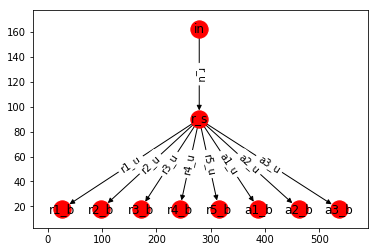

MDP network: (5,) inputs ('r_u',), (100, 1, 1, 1, 5, 5, 5, 5, 5) states ('r_s', 'r1_b', 'r2_b', 'r3_b', 'r4_b', 'r5_b', 'a1_b', 'a2_b', 'a3_b'), (100, 1, 1, 1, 5, 5, 5, 5, 5) outputs ('r_x', 'r1_b', 'r2_b', 'r3_b', 'r4_b', 'r5_b', 'a1_b', 'a2_b', 'a3_b')


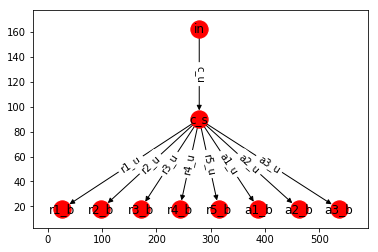

MDP network: (7,) inputs ('c_u',), (200, 1, 1, 1, 5, 5, 5, 5, 5) states ('c_s', 'r1_b', 'r2_b', 'r3_b', 'r4_b', 'r5_b', 'a1_b', 'a2_b', 'a3_b'), (200, 1, 1, 1, 5, 5, 5, 5, 5) outputs ('c_x', 'r1_b', 'r2_b', 'r3_b', 'r4_b', 'r5_b', 'a1_b', 'a2_b', 'a3_b')


In [3]:
# create systems
from best.models.pomdp import POMDPNetwork

# copter model
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2], name_prefix='c')

# Environment belief model
env_list = [rf.environment_belief_model(info[1], [1-prob['weak_accu'], prob['weak_accu']], name) 
            for (name, info) in regs.items()]

# Construct rover-env network
rover_env_network = POMDPNetwork([rover_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    rover_env_network.add_connection(['r_x'], '{}_u'.format(item[0]), rf.get_rover_env_conn(item))

# Construct copter-env network
copter_env_network = POMDPNetwork([copter_abstr.pomdp] + env_list)
for item in prob['regs'].items():
    copter_env_network.add_connection(['c_x'], '{}_u'.format(item[0]), rf.get_copter_env_conn(item, prob['cop_sight']))

rover_env_network.plot()
plt.show()
print (rover_env_network)

copter_env_network.plot()
plt.show()
print (copter_env_network)

In [4]:
# solve rover LTL problem
from best.solvers.valiter import solve_ltl_cosafe, solve_reach_constrained

predicates = rf.get_predicates(prob['regs'])
rover_ltlpol = solve_ltl_cosafe(rover_env_network, prob['formula'], predicates,
                                horizon=prob['rov_T'], verbose=True, delta=0.0001)

# set up target set
init_rov = rover_abstr.x_to_s(prob['rov_x0'])
init_dfsa = rover_ltlpol.dfsa_init
v_max = np.max(rover_ltlpol.val[0].flatten())
idx = np.logical_or(rover_ltlpol.val[0][init_rov, ..., init_dfsa] > v_max-prob['prob_margin'],
                    rover_ltlpol.val[0][init_rov, ..., init_dfsa] < prob['prob_margin'])
Vacc = np.zeros(copter_env_network.N)
Vacc[:, idx] = 1

# constraint set (landing)
Vcon = np.zeros(copter_env_network.N)
Vcon[copter_abstr.x_to_s(prob['cop_xT']), ...] = 1
val_copt_list, pol_copt_list = solve_reach_constrained(copter_env_network, 
                                                       Vacc, [(Vcon, 0.95)], 
                                                       horizon=prob['cop_T'], verbose=True)

constructing augmented network...
finished constructing augmented network in 0.64s
iteration 0, time 0.01
iteration 1, time 0.38
iteration 2, time 0.69
iteration 3, time 1.08
iteration 4, time 1.46
iteration 5, time 1.82
iteration 6, time 2.22
iteration 7, time 2.60
iteration 8, time 2.96
iteration 9, time 3.28
iteration 10, time 3.62
iteration 11, time 3.94
iteration 12, time 4.28
iteration 13, time 4.61
iteration 14, time 5.00
finished after 5.32s and 15 iterations
iteration 0, time 0.00
iteration 1, time 0.55
iteration 2, time 1.08
iteration 3, time 1.56
iteration 4, time 2.07
iteration 5, time 2.51
iteration 6, time 2.97
iteration 7, time 3.40
iteration 8, time 3.93
iteration 9, time 4.36
iteration 10, time 4.85
iteration 11, time 5.35
iteration 12, time 5.76
iteration 13, time 6.17
iteration 14, time 6.67
iteration 15, time 7.20
iteration 16, time 7.61
iteration 17, time 7.99
iteration 18, time 8.41
iteration 19, time 8.93
iteration 20, time 9.38
iteration 21, time 9.81
iteration 

In [5]:
# save controllers
copter_policy = rf.CopterPolicy(pol_copt_list, val_copt_list, copter_abstr)
rover_policy = rf.RoverPolicy(rover_ltlpol, rover_abstr)

if False:
    import cPickle as pickle
    with open('policies.pickle', 'wb') as fp:
      pickle.dump((copter_policy, rover_policy, prob), fp)

success probability: 0.943520724773407


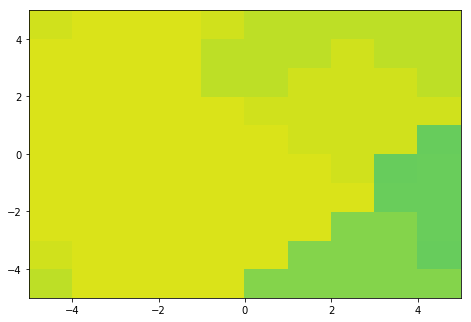

In [6]:
# plot rover value fcn
def my_value(x, mapstate):    
    s_abstr = rover_abstr.x_to_s(x)
    _, val = rover_ltlpol((s_abstr,) + tuple(mapstate))
    rover_ltlpol.reset()
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), prob['env_x0'])

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print ('success probability: {}'.format(my_value(prob['rov_x0'], prob['env_x0'])))

success value: 1.0


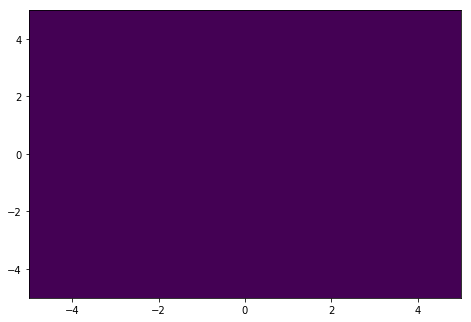

In [7]:
# plot copter value fcn
map_init = prob['env_x0'][:]

def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    return val_copt_list[0][(scop,) + tuple(mapstate)]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), map_init)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)
ax.pcolor(x, y, vals)

print ('success value: {}'.format(copter_value(prob['cop_x0'], map_init)))

execution ends at t=3.2
exploration ends at t=24.1
execution ends at t=30.8
execution ends at t=3.2
exploration ends at t=24.8
execution ends at t=24.8


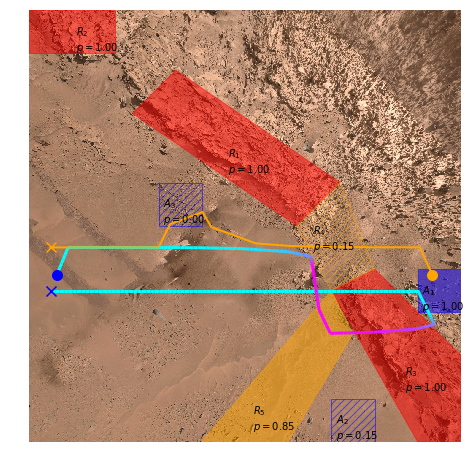

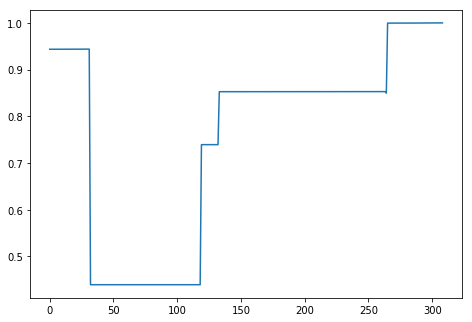

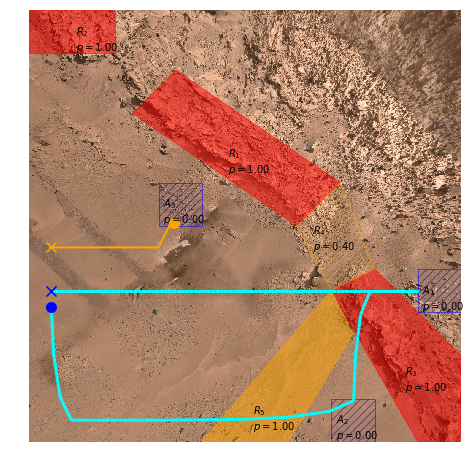

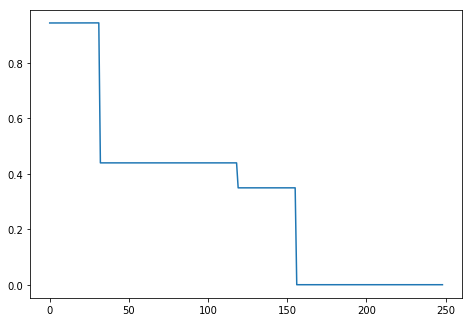

In [8]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import importlib

realmaps = [[0, 0, 0, 0, 4, 4, 0, 0], [0, 0, 0, 0, 4, 0, 0, 0]]

for iter in range(len(realmaps)):

    realmap = realmaps[iter]
    rover_policy.reset()
    copter_policy.reset()

    mapstate = prob['env_x0'][:]

    x_rover = prob['rov_x0'].reshape((1,2))
    x_copter = prob['cop_x0'].reshape((1,3))
    val = rover_policy.get_value(x_rover[-1,:], mapstate)

    psuccess = np.array([val])
    tvec = np.array([0])

    # rover execution
    while val > 0.85 and not rover_policy.finished():
        x_curr = x_rover[-1, :].flatten()
        
        mapstate = rf.reveal_map(mapstate, rf.rover_env_sim(x_curr, prob['regs']), realmap)
        belief = rover_env_network.transform_output((0,) + tuple(mapstate))[1:]
        APs = rf.rover_aps_sim(x_curr, belief, rover_env_network.output_names, predicates)
        
        x_next, val = rover_policy(x_curr, mapstate, APs)
            
        x_rover = np.vstack([x_rover, rf.small_step(x_curr, x_next)])
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print ('execution ends at t={:.1f}'.format(tvec[-1]))

    # send out copter
    while not copter_policy.finished():
        x_curr = x_copter[-1, :].flatten()
        
        mapstate = rf.reveal_map(mapstate, rf.copter_env_sim(x_curr, prob['regs'], prob['cop_sight']), realmap)
        x_next, val = copter_policy(x_curr, mapstate)
        
        x_copter = np.vstack([x_copter, rf.small_step(x_curr, x_next)])
    
        val = rover_policy.get_value(x_rover[-1,:], mapstate)
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print ('exploration ends at t={:.1f}'.format(tvec[-1]))

    mid_probs = copter_env_network.transform_output((0,) + tuple(mapstate))[1:]

    # rover execution again
    while val > 0.8 and not rover_policy.finished():
        x_curr = x_rover[-1, :].flatten()
        
        mapstate = rf.reveal_map(mapstate, rf.rover_env_sim(x_curr, prob['regs']), realmap)
        belief = rover_env_network.transform_output((0,) + tuple(mapstate))[1:]
        APs = rf.rover_aps_sim(x_curr, belief, rover_env_network.output_names, predicates)
        
        x_next, val = rover_policy(x_curr, mapstate, APs)
            
        x_rover = np.vstack([x_rover, rf.small_step(x_curr, x_next)])
        psuccess = np.hstack([psuccess, val])
        tvec = np.hstack([tvec, tvec[-1] + 0.1])

    print ('execution ends at t={:.1f}'.format(tvec[-1]))

    fig = plt.figure(figsize=(6, 6))
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.axis('off')
    image = mpimg.imread("surface.jpg")
    ax.imshow(image, extent=[-5, 5, -5, 5])

    i = 0
    for (name, info) in prob['regs'].items():
        if realmap[i] == 0 and info[1] != 1:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        rf.plot_region(ax, info[0], name, mid_probs[i], info[2], hatch=hatch, fill=fill)
        i += 1

    points = np.array([x_copter[:,0], x_copter[:,1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'))
    lc.set_array(x_copter[:, 2])
    lc.set_linewidth(3)
    ax.add_collection(lc)

    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)
    
    fig.savefig('exp1-{}-trajectory.pdf'.format(iter), bbox_inches='tight')
    
    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    ax.plot(psuccess)

    np.savetxt('exp1-{}-proba.txt'.format(iter),  np.vstack([psuccess, tvec]).T, delimiter=' ')